In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import sys
import os
sys.path.insert(0, os.path.abspath("."))

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from evaluate import load
import numpy as np

# import vllm
from tqdm import tqdm
from lib.preprocessing import preprocess_data
from lib.training_utils import train_model, translate_text


In [15]:
from evaluate import load

## Load the medline data and divide it into train and calibration set

In [9]:
data = load_dataset("sethjsa/medline_en_ru_parallel")

# shuffle with seed 42 and take last 1000 samples for calibration
data["calibration"] = data["train"].shuffle(seed=42).select(range(len(data["train"]) - 1000, len(data["train"])))

In [26]:
# remove duplicates from the calibration set
calibration_set = data["calibration"].to_pandas()
calibration_set = calibration_set.drop_duplicates(subset=["en", "ru"])
len(calibration_set)  # 917

917

## Load the model trained on 6500 samples (no calibration)

and translate the whole calibration set

In [12]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
model = AutoModelForSeq2SeqLM.from_pretrained("results/rq4/model_6500_medline")

In [28]:
predictions = translate_text(
    calibration_set["en"].to_list(),
    model,
    tokenizer,
    max_length=128,
    batch_size=64
)

Using device: cuda


Translating:   0%|                                                                                 | 0/15 [00:00<?, ?it/s]/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Translating: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [01:19<00:00,  5.31s/it]


In [29]:
calibration_set['predictions'] = predictions

# Assess the quality of each translation

In [30]:
comet_metrics = load("comet")

comet_score = comet_metrics.compute(
    predictions=calibration_set['predictions'],
    references=calibration_set["ru"],
    sources=calibration_set["en"],
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../home/scur2189/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
/home/scur2189/.conda/envs/nmt/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2189/.conda/envs/nmt/lib/python3.10/site-p ...
You are using the plain ModelCheckpoint callback. Consider using Lit

In [31]:
calibration_set['comet_score'] = comet_score['scores']

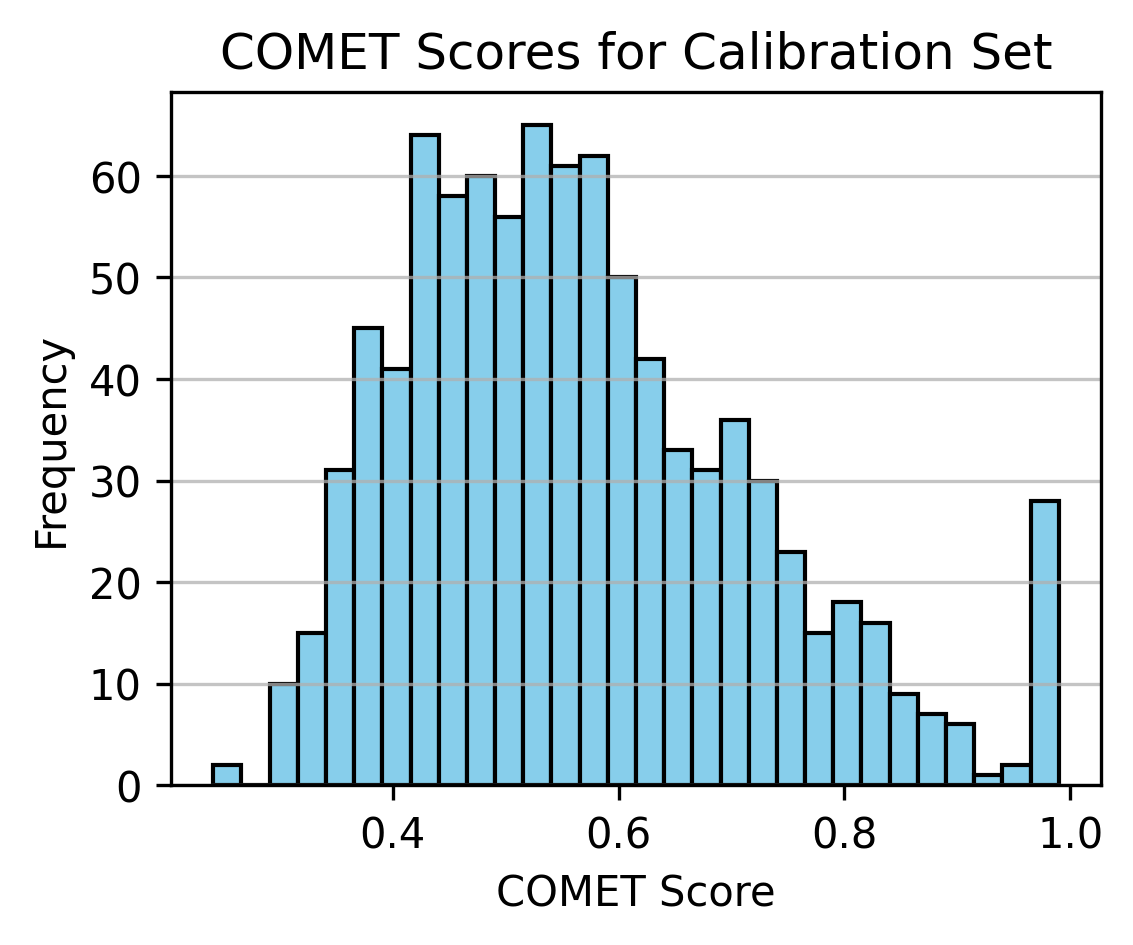

In [39]:
# generate a histogram of comet scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3), dpi=300)

scores = calibration_set['comet_score']

plt.title("COMET Scores for Calibration Set")

plt.xlabel("COMET Score")
plt.ylabel("Frequency")
plt.hist(scores, bins=30, color='skyblue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [ ]:
calibration_set.sort_values(by='comet_score', ascending=False)

,ru,en,predictions,comet_score
64,Материалы и методы.,SUBJECTS AND METHODS,Материалы и методы.,0.989800
579,Результаты и обсуждение.,RESULTS AND DISCUSSION,Результаты и обсуждение.,0.989779
37,Материал и методы.,MATERIAL AND METHODS,Материал и методы.,0.988926
41,Вывод,Conclusion,Вывод,0.987792
225,Заключение.,CONCLUSION,Заключение.,0.986503
...,...,...,...,...
395,Для оценки состояния больных использовались шк...,Concentrations of kappa and lambda FLC in the ...,Определяли концентрацию капппы и алмонды ФЛК в...,0.297237
760,В 62% случаев были выявлены нарушения режима л...,Approximately 62% of patients did not perform ...,Однако 62% пациентов с препаратами выполненных...,0.295484
266,В статье приводится краткий обзор описанных в ...,[Vestibular vertigo in hemispheric strokes].,"В статье представлены результаты исследований,...",0.292685
131,В обзорной статье рассматриваются транснациона...,[Children and adolescents in situations of soc...,Результаты и заключение. Результаты и заключение.,0.249010


In [ ]:
# save this calibration set to disk
calibration_set.to_csv('results/datasets/rq4/medline_1000_calibration_set.csv', index=False)